In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

In [2]:
import math
import itertools
from collections import defaultdict
from operator import itemgetter

import torch
import pandas as pd
# import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import normalize
from torch import nn
from torch.nn import functional as F
from tqdm.notebook import tqdm

from phoneme_lm import PhonemeLM, build_data_loader, build_vocab, encode_pronunciation
from utils import load_data, split_data

In [3]:
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

## Loading the Data ##

In [4]:
df = load_data(True)
len(df)

124996

In [5]:
phoneme_to_idx, idx_to_phoneme = build_vocab(df.pronunciation.values)
df['phoneme_ids'] = df.pronunciation.apply(lambda pronunciation: encode_pronunciation(pronunciation, phoneme_to_idx))

In [6]:
df['pronunciation_string'] = df.pronunciation.apply(' '.join)
df['length'] = df.pronunciation.apply(len)

In [7]:
train_df, dev_df, test_df = split_data(df, dev_proportion=.2, test_proportion=.01)
len(train_df), len(dev_df), len(test_df)

(98746, 25000, 1250)

## Training the Model ##

In [8]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cpu', rnn_type='gru',
    embedding_dimension=100, hidden_dimension=100, num_layers=1,
    max_epochs=10, early_stopping_rounds=5,
    lr=5e-3, batch_size=1024
)


lm.fit(train_df.pronunciation, dev_df.pronunciation)

Epoch 1: train loss: 0.5811	assess loss: 0.8998
	 M EY1 B AH0 L ER0 Z
	 JH AY1 K ER0
	 M UW0 R EH1 B AH0 L IH1 S
	 JH IH1 T HH EH1 N S
	 EY1 IY1 B AH0 N IY0 TH
Epoch 2: train loss: 0.5496	assess loss: 0.8524
	 M EH1 JH ER0 D
	 P UH1 CH
	 R AO1 B L D
	 B R OW1 EH1 R
	 F S B AH1 N JH AH0
Epoch 3: train loss: 0.5360	assess loss: 0.8330
	 F AO1 R D ER0
	 G OW2 K OW0 L HH IH1 T S K
	 D EH1 N T R AY0 HH OW1 SH T
	 R AY1 D AH0 L D S P EH0 F
	 G ER1 G R
Epoch 4: train loss: 0.5276	assess loss: 0.8207
	 B IH1 L ER0
	 M EY1 T ER0 ER0
	 L AO1 NG ER0
	 K AA1 R B AH0 S T
	 AE1 N TH OW0 T IH0 K S


KeyboardInterrupt: 

In [9]:
lm.generate(100, 1)

['AE1', 'N', 'AH0', 'N', 'K', 'UW2', 'CH']

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'batch_size': [2**7, 2**10, 2**12, 2**14],
#     'lr': [1e-4, 1e-3, 1e-2, 1e-1]
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(
#         phoneme_to_idx, device='cuda', rnn_type='gru', embedding_dimension=50, hidden_dimension=50,
#          max_epochs=200, early_stopping_rounds=3,
#         **params
#     )
    
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
# models_df.sort_values('train_loss')

In [ ]:
# models_df.sort_values('dev_loss')

In [ ]:
g = models_df.groupby(['batch_size', 'lr'])

columns = 3
rows = int(math.ceil(len(g) / columns))
fig, axs = plt.subplots(rows, columns, figsize=(20, 10), sharey=True)
for idx, ((embedding_dimension, rnn_hidden_dimension), t) in enumerate(g):
    row, column = divmod(idx, columns)
    ax = axs[row][column]
    t.set_index('epoch').dev_loss.plot(ax=ax)
    t.set_index('epoch').train_loss.plot(ax=ax)
    ax.set_title(f'batch_size={embedding_dimension}, lr={rnn_hidden_dimension}')
    plt.tight_layout()
    plt.yscale('log')

In [ ]:
print(models_df.batch_size.unique())
print(models_df.lr.unique())

In [ ]:
models_df[models_df.batch_size==16384].sort_values('train_loss')

In [ ]:
def plot(df, batch_size, lr):
    t = models_df[(models_df.batch_size==batch_size) & (models_df.lr==lr)].set_index('epoch')
    t.train_loss.plot()
    t.dev_loss.plot()
plot(df, 1024, .1)

In [ ]:
# 63 minutes for 16 models. 4 minutes each

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'rnn_type': ['gru'],
#     'embedding_dimension': [10, 50, 100, 200],
#     'rnn_hidden_dimension': [50, 100, 200, 400],
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=10)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df.embedding_dimension.unique()

In [ ]:
models_df = pd.DataFrame.from_records(records)
models_df.sort_values('dev_loss')
t = models_df[(models_df.embedding_dimension==10) & (models_df.rnn_hidden_dimension==200)]
t.set_index('epoch').train_loss.plot()
t.set_index('epoch').dev_loss.plot()

In [ ]:
# %%time

# param_grid = ParameterGrid({
#     'rnn_type': ['gru'],
#     'embedding_dimension': [10, 100, 400],
#     'rnn_hidden_dimension': [50, 200, 400],
# })

# records = []
# for params in tqdm(param_grid):
#     lm = PhonemeLM(phoneme_to_idx, device='cuda', batch_size=1024,  max_epochs=200, **params)
#     print('Model Params:', params)
#     train_losses, dev_losses = lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=3)
#     for epoch, (train_loss, dev_loss) in enumerate(zip(train_losses, dev_losses), start=1):
#         record = params.copy()
#         record['epoch'] = epoch
#         record['train_loss'] = train_loss
#         record['dev_loss'] = dev_loss
    
#         records.append(record)

# models_df = pd.DataFrame.from_records(records)

In [ ]:
models_df = pd.DataFrame.from_records(records)

In [ ]:
len(models_df)

In [ ]:
models_df.sort_values('train_loss')

In [ ]:
%%time

lm = PhonemeLM(
    phoneme_to_idx, device='cpu',
    rnn_type='gru', embedding_dimension=10, rnn_hidden_dimension=20,
    max_epochs=10
)

lm.fit(train_df.pronunciation, dev_df.pronunciation, early_stopping_rounds=10)

In [ ]:
%%time

lm.fit(train_df.pronunciation, dev_df.pronunciation, max_epochs=5, early_stopping_rounds=5)

In [ ]:
lm = torch.load('lm_1.pt', map_location=torch.device('cpu'))
lm.device = torch.device('cpu')

## Probability of Real Words ##

In [132]:
%%time

df['probability'] = df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

CPU times: user 11min 16s, sys: 13.2 s, total: 11min 29s
Wall time: 3min 1s


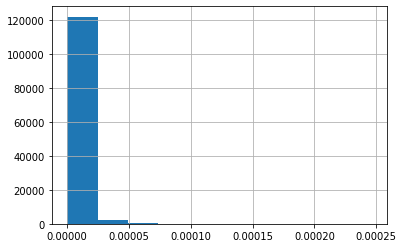

In [133]:
df.sort_values('probability', ascending=False, inplace=True)
df.probability.hist(bins=10)

In [ ]:
ta = train_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))
da = dev_df.pronunciation.apply(lambda pronunciation: lm.calculate_probability(pronunciation))

In [ ]:
ta.mean(), da.mean()

In [ ]:
ta.describe()

In [ ]:
da.describe()

In [ ]:
df[df.length == 3]

### Comparing Multiple Pronunciations ###

In [134]:
df[df.word == 'with'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
122549,with,"[W, IH1, TH]","[1, 58, 55, 18, 2]",W IH1 TH,3,3.002190e-05
122548,with,"[W, IH1, DH]","[1, 58, 55, 64, 2]",W IH1 DH,3,9.310457e-07
122550,with,"[W, IH0, TH]","[1, 58, 32, 18, 2]",W IH0 TH,3,9.503819e-08
122551,with,"[W, IH0, DH]","[1, 58, 32, 64, 2]",W IH0 DH,3,1.724583e-09


In [136]:
df[df.word == 'tomato'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
113135,tomato,"[T, AH0, M, AA1, T, OW2]","[1, 5, 3, 19, 10, 5, 30, 2]",T AH0 M AA1 T OW2,6,1.421234e-09
113134,tomato,"[T, AH0, M, EY1, T, OW2]","[1, 5, 3, 19, 4, 5, 30, 2]",T AH0 M EY1 T OW2,6,1.273807e-09


In [ ]:
df[df.word=='pajamas'].sort_values('probability', ascending=False)

In [139]:
df[df.word == 'february'].sort_values('probability', ascending=False)

,word,pronunciation,phoneme_ids,pronunciation_string,length,probability
38408,february,"[F, EH1, B, AH0, W, EH2, R, IY0]","[1, 51, 23, 11, 3, 58, 46, 6, 31, 2]",F EH1 B AH0 W EH2 R IY0,8,1.367271e-10
38407,february,"[F, EH1, B, Y, AH0, W, EH2, R, IY0]","[1, 51, 23, 11, 56, 3, 58, 46, 6, 31, 2]",F EH1 B Y AH0 W EH2 R IY0,9,8.802322e-12
38411,february,"[F, EH1, B, Y, UW0, W, EH2, R, IY0]","[1, 51, 23, 11, 56, 45, 58, 46, 6, 31, 2]",F EH1 B Y UW0 W EH2 R IY0,9,3.254394e-12
38410,february,"[F, EH1, B, UW0, W, EH2, R, IY0]","[1, 51, 23, 11, 45, 58, 46, 6, 31, 2]",F EH1 B UW0 W EH2 R IY0,8,3.159944e-12
38409,february,"[F, EH1, B, R, UW0, W, EH2, R, IY0]","[1, 51, 23, 11, 6, 45, 58, 46, 6, 31, 2]",F EH1 B R UW0 W EH2 R IY0,9,1.072626e-12


In [138]:
df.word.value_counts()

february         5
slanted          4
scientists       4
documentaries    4
directives       4
                ..
beguiling        1
inglett          1
marolf           1
perfetti         1
yin              1
Name: word, Length: 115533, dtype: int64

In [ ]:
lm.calculate_probability(['P', 'R', 'IH1', 'F', 'S'])

In [ ]:
lm.calculate_probability(['P', 'R', 'IH1', 'F'])

In [ ]:
lm.calculate_probability(['S', 'T', 'R', 'UW1', 'Z'])

### GENERATE PRONUNCIATIONS ###

In [10]:
for _ in range(10):
    pronunciation = lm.generate(100, temperature=None)
    pronunciation_string = ' '.join(pronunciation)
    matches = df[df.pronunciation_string == pronunciation_string]
    
    print(pronunciation_string)
    if len(matches) > 0:
        print('\t', matches.iloc[0]['word'], len(matches), 'total')
    print()

F AE1 L AA0

S T EH1 L K EH2 N

B AO1 L V ER0

K L EH1 N

AA1 R D D

P EH1 N K AE2 S T

N EY1 B EH2 K

D EH1 M ER0
	 dehmer 2 total

S T EY1 L ER0
	 staebler 1 total

M EH0 N D IY1 N OW0



### Probability of Next ###

In [142]:
pronunciation = ['CH', 'EH0', 'N', 'V', 'AY2', 'R', 'AH0', 'N', 'M', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
# pronunciation = ['M', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
# pronunciation = ['S', 'EH1', 'N', 'T', 'AH0', 'L', 'IH2']
pronunciation = ['F', 'EH1', 'B', 'Y', 'AH0']


next_probs = lm.next_probabilities(pronunciation)

for phoneme, probability in sorted(next_probs.items(), key=lambda p: -p[1]):
    print(f'[{probability:.4f}] {phoneme}')

[0.4441] L
[0.2840] N
[0.0609] </W>
[0.0428] T
[0.0423] S
[0.0201] K
[0.0162] F
[0.0143] Z
[0.0131] G
[0.0131] M
[0.0069] D
[0.0052] W
[0.0048] B
[0.0046] TH
[0.0043] P
[0.0039] SH
[0.0034] R
[0.0029] HH
[0.0021] CH
[0.0019] JH
[0.0012] AH0
[0.0011] V
[0.0010] EY2
[0.0008] NG
[0.0006] Y
[0.0004] ER0
[0.0003] OW2
[0.0003] AA2
[0.0003] DH
[0.0003] ZH
[0.0002] AO2
[0.0002] UW2
[0.0002] AE2
[0.0001] AA0
[0.0001] EH2
[0.0001] OY2
[0.0001] EH0
[0.0001] AW2
[0.0001] AO0
[0.0001] ER2
[0.0001] EY1
[0.0001] IH0
[0.0001] EY0
[0.0001] IY0
[0.0001] AE0
[0.0001] OW0
[0.0001] AH2
[0.0001] UW0
[0.0001] AY2
[0.0001] AY0
[0.0001] AW0
[0.0001] EH1
[0.0000] IH2
[0.0000] OY0
[0.0000] IY2
[0.0000] AE1
[0.0000] UH0
[0.0000] UH2
[0.0000] UW1
[0.0000] OW1
[0.0000] <W>
[0.0000] AA1
[0.0000] UW
[0.0000] <PAD>
[0.0000] IH1
[0.0000] UH1
[0.0000] AO1
[0.0000] IY1
[0.0000] AH1
[0.0000] AW1
[0.0000] OY1
[0.0000] ER1
[0.0000] AY1


In [ ]:
def probability_next(lm, pronunciation):
    

In [ ]:
lm.calculate_probability(['S'])

In [ ]:
encode_pronunciation(['S'], lm.phoneme_to_idx)

In [ ]:
lm

In [ ]:
torch.save(lm, 'lm.pt')

### Play with Embeddings ###

In [ ]:
def most_similar_phonemes(lm, embedding, topn=10):
    other_to_sim = {
        phoneme: cosine_similarity(lm.embedding_for(phoneme), embedding).item()
        for phoneme in phoneme_to_idx

    }

    for other_phoneme, similarity in sorted(other_to_sim.items(), key=lambda p: -p[1])[:topn]:
        print(f'[{similarity:.3f}]\t{other_phoneme}')
        
most_similar_phonemes(lm, lm.embedding_for('DH'))

In [ ]:
embeddings = lm.embeddings
# embeddings = lm.embedding.weight.cpu().detach().numpy()
normed_embeddings = normalize(embeddings)

num_clusters = 15
kmeans = KMeans(num_clusters)
kmeans.fit(normed_embeddings)

grouped = defaultdict(set)
for idx, label in enumerate(kmeans.labels_):
    phoneme = lm.vocab[idx]
    grouped[label].add(phoneme)
grouped

In [ ]:
# For consonants
# - voicing
# - place: bilabial, dental, alveolar, palatal, velar
# - manner: stop, fricative, nasal

# For vowels
# - front/back
# - closed/open
# - rounding

# General
# - syllabic

# TODO: combine multiple vectors together, e.g. {B, G, V, DH, D} for voiced
voicing = lm.embedding_for('B') - lm.embedding_for('P')
forwarding = lm.embedding_for('P') - lm.embedding_for('K')
frication = lm.embedding_for('F') - lm.embedding_for('P')

# new = lm.embedding_for('TH') + voicing
# new = lm.embedding_for('K') + voicing
# new = lm.embedding_for('T') + frication
new = lm.embedding_for('G') + forwarding

phoneme_to_sim = {}
for phoneme in phoneme_to_idx:
    this_embs = lm.embedding_for(phoneme)
    sim = cosine_similarity(new, this_embs).item()
    phoneme_to_sim[phoneme] = sim

sorted(phoneme_to_sim.items(), key=lambda p: -p[1])[:5]

In [ ]:
import numpy as np
# np.mean([embedding_for('B'), embedding_for('V')], axis=0)
voiced = np.mean([lm.embedding_for(phoneme) for phoneme in ['B', 'V', 'G', 'Z', 'ZH', 'DH', 'JH']], axis=0)
voiceless = np.mean([lm.embedding_for(phoneme) for phoneme in ['P', 'F', 'K', 'S', 'SH', 'TH', 'CH']], axis=0)
voicing = voiced - voiceless
most_similar_phonemes(lm, voicing + lm.embedding_for('S'))

In [ ]:
most_similar_phonemes(lm, voicing)

In [ ]:
from phoneme_lm import START, END, PAD
def analogy(lm, a, b, c):
    """
    a - b = c - w
    argmax(w) over sim(w, c - a + b)
    """
    emb_a = lm.embedding_for(a)
    emb_b = lm.embedding_for(b)
    emb_c = lm.embedding_for(c)
    
    all_phonemes = set(lm.vocab) - {START, END, PAD}
    
    phoneme_to_sim = {}
    for phoneme in all_phonemes:
        if phoneme in {a, b, c}:
            continue
        
        emb_p = lm.embedding_for(phoneme)
        sim = cosine_similarity(emb_p, emb_c - emb_a + emb_b)
        phoneme_to_sim[phoneme] = sim.item()
    return phoneme_to_sim

analogies = analogy(lm, 'P', 'K', 'B')
for phoneme, sim in sorted(analogies.items(), key=lambda p: -p[1]):
    print(f'[{sim:.4f}] {phoneme}')


In [ ]:
from phoneme_lm import START
phoneme_idx = lm.phoneme_to_idx[START]

In [ ]:
output, hidden_state = lm(torch.LongTensor([phoneme_idx]).unsqueeze(0))

In [ ]:
hidden_state.shape

In [ ]:
hidden = torch.zeros(1, 1, 10)

lm(torch.LongTensor([phoneme_idx]).unsqueeze(0), hidden)